## DrCoding Analysis

### Notes
- All analysis here are based off of commands run remotely on a Azure NV6_Promo (6 vcpus, 56 GiB memory) instance with a Tesla M60 GPU
- Analysis is done using logs obtained after running the commands remotely


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
plt.style.use('seaborn-whitegrid')

In [2]:
def read_logs_for_training_graph_per_iteration(log_file):
    with open(log_file) as f:
        iterations = []
        losses = []
        speeds = []
        time_takens = []
        epoch = 1
        
        for row in f:
            if row.startswith("epoch"):
                row_arr = row.strip().split(" ")
                iteration = int(row_arr[3].replace(",", ""))
                iterations.append(iteration)
                loss = float(row_arr[6])
                losses.append(loss)
                speed = float(row_arr[11])
                speeds.append(speed)
                time_taken = float(row_arr[-2])
                time_takens.append(time_taken)
        return iterations, losses, speeds, time_takens

def read_logs_for_training_graph_per_epoch(log_file):
    with open(log_file) as f:
        epoch_map = {}
        
        for row in f:
            if row.startswith("epoch"):
                row_arr = row.strip().split(" ")
                epoch = int(row_arr[1].replace(",", ""))
                if epoch not in epoch_map:
                    epoch_map[epoch] = {
                        "iterations": [],
                        "losses": [],
                        "speeds": [],
                        "time_takens": []
                    }
                iteration = int(row_arr[3].replace(",", ""))
                epoch_map[epoch]["iterations"].append(iteration)
                loss = float(row_arr[6])
                epoch_map[epoch]["losses"].append(loss)
                speed = float(row_arr[11])
                epoch_map[epoch]["speeds"].append(speed)
                time_taken = float(row_arr[-2])
                epoch_map[epoch]["time_takens"].append(time_taken)
        
        epochs = []
        losses = []
        speeds = []
        time_takens = []
        for k in sorted(epoch_map.keys()):
            epochs.append(k)
            losses.append(np.mean(epoch_map[k]["losses"]))
            speeds.append(np.mean(epoch_map[k]["speeds"]))
            time_takens.append(np.mean(epoch_map[k]["time_takens"]))
        
        return epochs, losses, speeds, time_takens    

def read_logs_for_validation_graph_per_iteration(log_file):
    # eg. VALIDATION: 1000 | Precision 0.06152534113060429, recall 0.028759688573285154, f1 0.0375234962406015, accuracy: 0.8817714424950978
    with open(log_file) as f:
        iterations = []
        precisions = []
        recalls = []
        f1s = []
        accuracies = []
        
        for row in f:
            if row.startswith("VALIDATION"):
                row_arr = row.strip().split(" ")
                iteration = int(row_arr[1])
                iterations.append(iteration)
                precision = float(row_arr[4].replace(",", ""))
                precisions.append(precision)
                recall = float(row_arr[6].replace(",", ""))
                recalls.append(recall)
                f1 = float(row_arr[8].replace(",", ""))
                f1s.append(f1)
                accuracy = float(row_arr[10].replace(",", ""))
                accuracies.append(accuracy)
            elif "drcoding -   VALIDATION" in row:
                row_arr = row.strip().split(" ")
                # ['03/12/2020', '05:12:43', '-', 'INFO', '-', 'drcoding', '-', '', '', 'VALIDATION:', '100', '|', 'Precision', '0.31846978557505096,', 'recall', '0.2723213099741746,', 'f1', '0.2739054192661439,', 'accuracy:', '0.8444883040935726']
                iteration = int(row_arr[10])
                iterations.append(iteration)
                precision = float(row_arr[13].replace(",", ""))
                precisions.append(precision)
                recall = float(row_arr[15].replace(",", ""))
                recalls.append(recall)
                f1 = float(row_arr[17].replace(",", ""))
                f1s.append(f1)
                accuracy = float(row_arr[19].replace(",", ""))
                accuracies.append(accuracy)
                
                
        return iterations, precisions, recalls, f1s, accuracies


def read_logs_for_validation_graph_per_epoch(log_file):
    with open(log_file) as f:
        epoch_map = {}
        
        epoch = 1
        for row in f:
            if row.startswith("epoch"):
                row_arr = row.strip().split(" ")
                epoch = int(row_arr[1].replace(",", ""))
                if epoch not in epoch_map:
                    epoch_map[epoch] = {
                        "precisions": [],
                        "recalls": [],
                        "f1s": [],
                        "accuracies": []
                    }

            if row.startswith("VALIDATION"):
                row_arr = row.strip().split(" ")
                precision = float(row_arr[4].replace(",", ""))
                epoch_map[epoch]["precisions"].append(precision)
                recall = float(row_arr[6].replace(",", ""))
                epoch_map[epoch]["recalls"].append(recall)
                f1 = float(row_arr[8].replace(",", ""))
                epoch_map[epoch]["f1s"].append(f1)
                accuracy = float(row_arr[10].replace(",", ""))
                epoch_map[epoch]["accuracies"].append(accuracy)
            elif "drcoding -   VALIDATION" in row:
                row_arr = row.strip().split(" ")
                # ['03/12/2020', '05:12:43', '-', 'INFO', '-', 'drcoding', '-', '', '', 'VALIDATION:', '100', '|', 'Precision', '0.31846978557505096,', 'recall', '0.2723213099741746,', 'f1', '0.2739054192661439,', 'accuracy:', '0.8444883040935726']
                precision = float(row_arr[13].replace(",", ""))
                epoch_map[epoch]["precisions"].append(precision)
                recall = float(row_arr[15].replace(",", ""))
                epoch_map[epoch]["recalls"].append(recall)
                f1 = float(row_arr[17].replace(",", ""))
                epoch_map[epoch]["f1s"].append(f1)
                accuracy = float(row_arr[19].replace(",", ""))
                epoch_map[epoch]["accuracies"].append(accuracy)
                
        epochs = []
        precisions = []
        recalls = []
        f1s = []
        accuracies = []
        for k in sorted(epoch_map.keys()):
            epochs.append(k)
            precisions.append(np.mean(epoch_map[k]["precisions"]))
            recalls.append(np.mean(epoch_map[k]["recalls"]))
            f1s.append(np.mean(epoch_map[k]["f1s"]))
            accuracies.append(np.mean(epoch_map[k]["accuracies"]))
        
        return epochs, precisions, recalls, f1s, accuracies    

    
def print_total_training_time(log_file):
    with open(log_file) as f:
        start_time = ""
        end_time = ""
        for row in f:
            if "- INFO -" in row:
                
                print(row)
                t = row.split("- INFO -")[0].strip()
                end_time = t
                if start_time == "":
                    start_time = t
        print("Start Time = {}".format(start_time))
        print("End Time = {}".format(end_time))
        
        start_time = time.strptime(start_time, '%m/%d/%Y %H:%M:%S')
        end_time = time.strptime(end_time, '%m/%d/%Y %H:%M:%S')
        print("Total Time = {}".format(end_time - start_time))
        

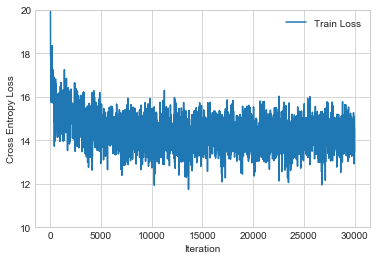

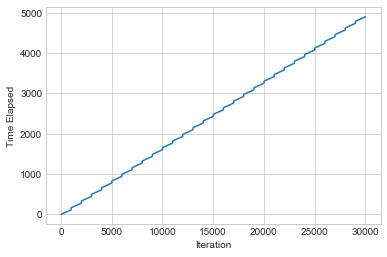

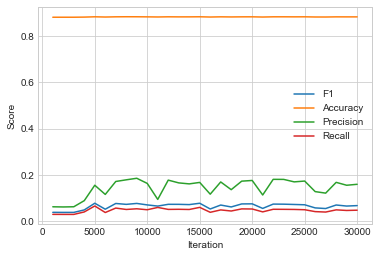

In [137]:
#
# Training Loss Over Time
#

iterations, losses, speeds, time_takens = read_logs_for_training_graph_per_iteration("../logs/nohup.out.transformer.3")
# print_total_training_time("../logs/nohup.out.transformer.3")
iterations_validation, precisions, recalls, f1s, accuracies = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.transformer.3")

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.plot(iterations, losses, label='Train Loss')
# plt.plot(hist['epoch'], hist['val_mae'],
#        label = 'Val Error')
plt.ylim([10, 20])
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Time Elapsed')
plt.plot(iterations, time_takens)
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.plot(iterations_validation, f1s, label='F1')
plt.plot(iterations_validation, accuracies, label='Accuracy')
plt.plot(iterations_validation, precisions, label='Precision')
plt.plot(iterations_validation, recalls, label='Recall')
plt.legend()
plt.show()



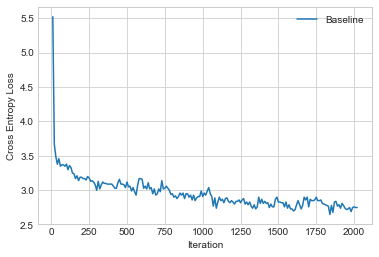

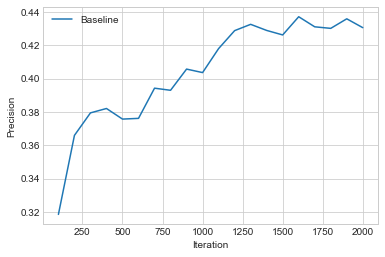

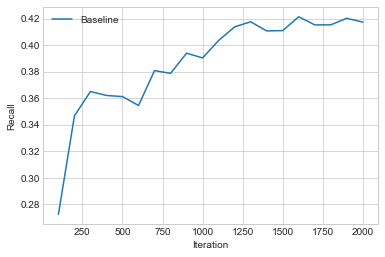

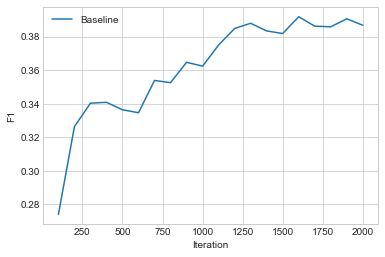

In [138]:
# 
# Baseline
# 

iterations, losses, speeds, time_takens = read_logs_for_training_graph_per_iteration("../logs/nohup.out.baseline.2")
iterations_validation_1, precisions_1, recalls_1, f1s_1, accuracies_1 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.baseline.2")

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.plot(iterations, losses, label='Baseline')
plt.legend()
plt.show()



plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.plot(iterations_validation_1, precisions_1, label='Baseline')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.plot(iterations_validation_1, recalls_1, label='Baseline')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('F1')
plt.plot(iterations_validation_1, f1s_1, label='Baseline')
plt.legend()
plt.show()





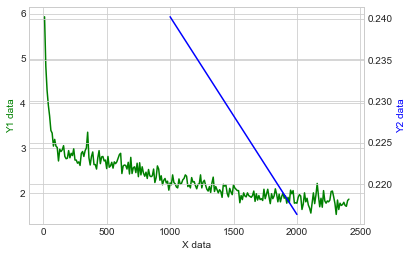

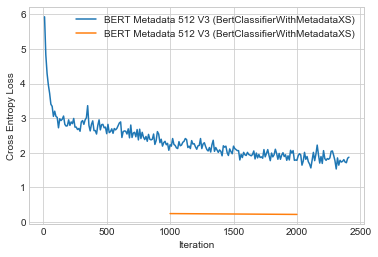

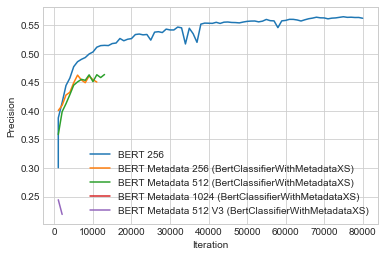

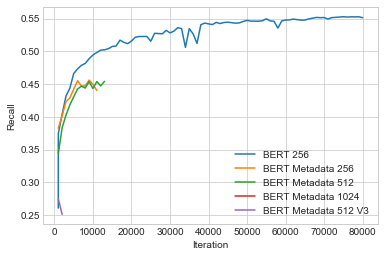

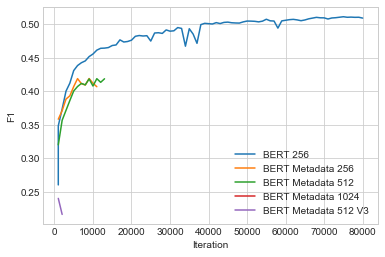

In [56]:
#
# BERT vs BERT Metadata Training Loss Over Time
#

iterations, losses, speeds, time_takens = read_logs_for_training_graph_per_iteration("../logs/nohup.out.bert.2")
iterations_4, losses_4, speeds_4, time_takens_4 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.bert.metadata.4")
iterations_5, losses_5, speeds_5, time_takens_5 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.bert.metadata.5")
iterations_6, losses_6, speeds_6, time_takens_6 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.bert.metadata.6")
iterations_7, losses_7, speeds_7, time_takens_7 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.bert.metadata.v3.8")




iterations_validation_1, precisions_1, recalls_1, f1s_1, accuracies_1 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.bert.2")
iterations_validation_4, precisions_4, recalls_4, f1s_4, accuracies_4 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.bert.metadata.4")
iterations_validation_5, precisions_5, recalls_5, f1s_5, accuracies_5 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.bert.metadata.5")
iterations_validation_6, precisions_6, recalls_6, f1s_6, accuracies_6 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.bert.metadata.6")
iterations_validation_7, precisions_7, recalls_7, f1s_7, accuracies_7 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.bert.metadata.v3.8")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(iterations_7, losses_7, 'g-')
ax2.plot(iterations_validation_7, f1s_7, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
# plt.plot(iterations, losses, label='BERT 256')
# plt.plot(iterations_4, losses_4, label='BERT Metadata 256 (BertClassifierWithMetadataXS)')
# plt.plot(iterations_5, losses_5, label='BERT Metadata 512 (BertClassifierWithMetadataXS)')
# plt.plot(iterations_6, losses_6, label='BERT Metadata 1024 (BertClassifierWithMetadataXS)')
plt.plot(iterations_7, losses_7, label='BERT Metadata 512 V3 (BertClassifierWithMetadataXS)')
plt.plot(iterations_validation_7, f1s_7, label='BERT Metadata 512 V3 (BertClassifierWithMetadataXS)')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.plot(iterations_validation_1, precisions_1, label='BERT 256')
plt.plot(iterations_validation_4, precisions_4, label='BERT Metadata 256 (BertClassifierWithMetadataXS)')
plt.plot(iterations_validation_5, precisions_5, label='BERT Metadata 512 (BertClassifierWithMetadataXS)')
plt.plot(iterations_validation_6, precisions_6, label='BERT Metadata 1024 (BertClassifierWithMetadataXS)')
plt.plot(iterations_validation_7, precisions_7, label='BERT Metadata 512 V3 (BertClassifierWithMetadataXS)')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.plot(iterations_validation_1, recalls_1, label='BERT 256')
plt.plot(iterations_validation_4, recalls_4, label='BERT Metadata 256')
plt.plot(iterations_validation_5, recalls_5, label='BERT Metadata 512')
plt.plot(iterations_validation_6, recalls_6, label='BERT Metadata 1024')
plt.plot(iterations_validation_7, recalls_7, label='BERT Metadata 512 V3')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('F1')
plt.plot(iterations_validation_1, f1s_1, label='BERT 256')
plt.plot(iterations_validation_4, f1s_4, label='BERT Metadata 256')
plt.plot(iterations_validation_5, f1s_5, label='BERT Metadata 512')
plt.plot(iterations_validation_6, f1s_6, label='BERT Metadata 1024')
plt.plot(iterations_validation_7, f1s_7, label='BERT Metadata 512 V3')
plt.legend()
plt.show()


Reformer 2048: 27689.077983797877 words/sec
Reformer 512: 27420.527012975363 words/sec
Reformer 256: 26712.714573006586 words/sec
Improvement F1 (2048 vs 256): nan
Improvement F1 (2048 vs 256): nan
Reformer 2048: 0.4895166175979945
Reformer 512: 0.45438570627180563
Reformer 256: 0.42534894244167537


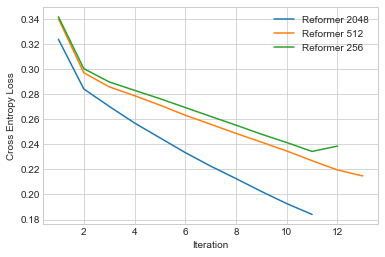

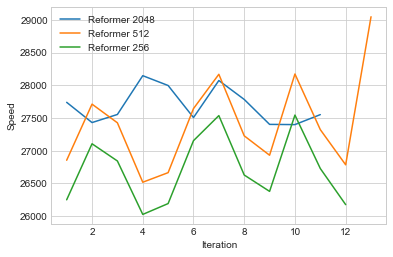

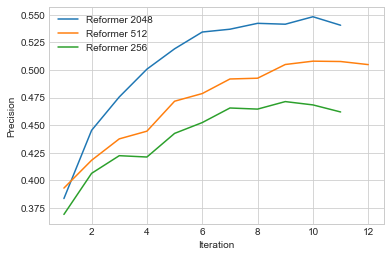

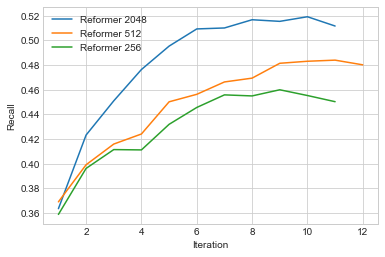

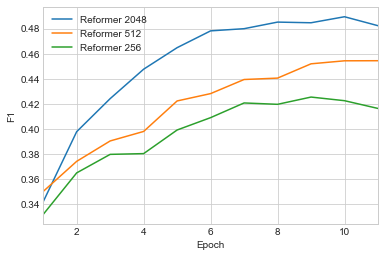

In [52]:
#
# Reformer - input length improves performance
#

iterations_2, losses_2, speeds_2, time_takens_2 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.4")
iterations_3, losses_3, speeds_3, time_takens_3 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.5")
iterations_4, losses_4, speeds_4, time_takens_4 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.6")

iterations_2, losses_2, speeds_2, time_takens_2 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.reformer.4")
iterations_3, losses_3, speeds_3, time_takens_3 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.reformer.5")
iterations_4, losses_4, speeds_4, time_takens_4 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.reformer.6")



iterations_validation_2, precisions_2, recalls_2, f1s_2, accuracies_2 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.4")
iterations_validation_3, precisions_3, recalls_3, f1s_3, accuracies_3 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.5")
iterations_validation_4, precisions_4, recalls_4, f1s_4, accuracies_4 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.6")


print("Reformer 2048: {} words/sec".format(np.mean(speeds_2)))
print("Reformer 512: {} words/sec".format(np.mean(speeds_3)))
print("Reformer 256: {} words/sec".format(np.mean(speeds_4)))
print("Improvement F1 (2048 vs 256): {}".format(np.max(f1s_2) - np.max(f1s_4)))
print("Improvement F1 (2048 vs 256): {}".format(np.max(f1s_2) - np.max(f1s_3)))

print("Reformer 2048: {}".format(np.max(f1s_2)))
print("Reformer 512: {}".format(np.max(f1s_3[:-1])))
print("Reformer 256: {}".format(np.max(f1s_4[:-1])))

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.plot(iterations_2, losses_2, label='Reformer 2048')
plt.plot(iterations_3, losses_3, label='Reformer 512')
plt.plot(iterations_4, losses_4, label='Reformer 256')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Speed')
plt.plot(iterations_2, speeds_2, label='Reformer 2048')
plt.plot(iterations_3, speeds_3, label='Reformer 512')
plt.plot(iterations_4, speeds_4, label='Reformer 256')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.plot(iterations_validation_2, precisions_2, label='Reformer 2048')
plt.plot(iterations_validation_3, precisions_3, label='Reformer 512')
plt.plot(iterations_validation_4, precisions_4, label='Reformer 256')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.plot(iterations_validation_2, recalls_2, label='Reformer 2048')
plt.plot(iterations_validation_3, recalls_3, label='Reformer 512')
plt.plot(iterations_validation_4, recalls_4, label='Reformer 256')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.plot(iterations_validation_2, f1s_2, label='Reformer 2048')
plt.plot(iterations_validation_3, f1s_3, label='Reformer 512')
plt.plot(iterations_validation_4, f1s_4, label='Reformer 256')
plt.xlim([1, 11])
plt.legend()
plt.show()


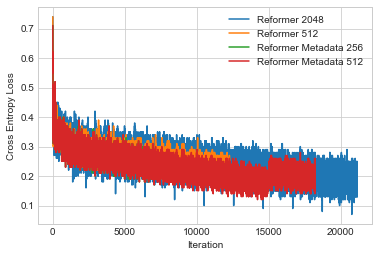

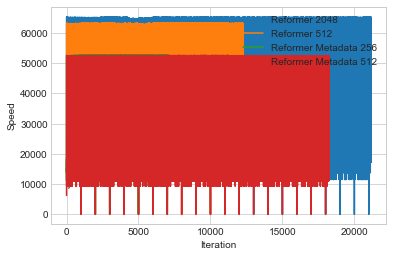

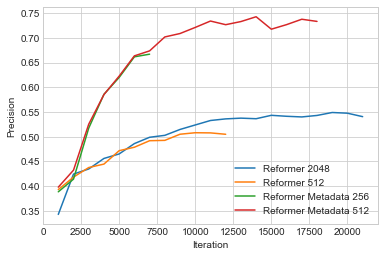

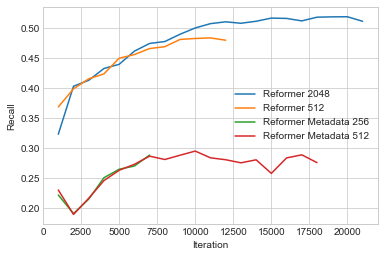

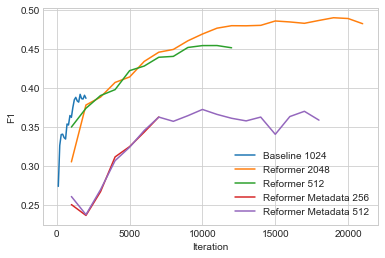

In [27]:
#
# BERT vs BERT Metadata Training Loss Over Time
#

iterations_1, losses_1, speeds_1, time_takens_1 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.baseline.2")
iterations_2, losses_2, speeds_2, time_takens_2 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.4")
iterations_3, losses_3, speeds_3, time_takens_3 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.5")
iterations_4, losses_4, speeds_4, time_takens_4 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.metadata.2")
iterations_5, losses_5, speeds_5, time_takens_5 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.metadata.3")


iterations_validation_1, precisions_1, recalls_1, f1s_1, accuracies_1 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.baseline.2")
iterations_validation_2, precisions_2, recalls_2, f1s_2, accuracies_2 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.reformer.4")
iterations_validation_3, precisions_3, recalls_3, f1s_3, accuracies_3 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.reformer.5")
iterations_validation_4, precisions_4, recalls_4, f1s_4, accuracies_4 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.reformer.metadata.2")
iterations_validation_5, precisions_5, recalls_5, f1s_5, accuracies_5 = read_logs_for_validation_graph_per_iteration("../logs/nohup.out.reformer.metadata.3")


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.plot(iterations_2, losses_2, label='Reformer 2048')
plt.plot(iterations_3, losses_3, label='Reformer 512')
plt.plot(iterations_4, losses_4, label='Reformer Metadata 256')
plt.plot(iterations_5, losses_5, label='Reformer Metadata 512')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Speed')
plt.plot(iterations_2, speeds_2, label='Reformer 2048')
plt.plot(iterations_3, speeds_3, label='Reformer 512')
plt.plot(iterations_4, speeds_4, label='Reformer Metadata 256')
plt.plot(iterations_5, speeds_5, label='Reformer Metadata 512')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.plot(iterations_validation_2, precisions_2, label='Reformer 2048')
plt.plot(iterations_validation_3, precisions_3, label='Reformer 512')
plt.plot(iterations_validation_4, precisions_4, label='Reformer Metadata 256')
plt.plot(iterations_validation_5, precisions_5, label='Reformer Metadata 512')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.plot(iterations_validation_2, recalls_2, label='Reformer 2048')
plt.plot(iterations_validation_3, recalls_3, label='Reformer 512')
plt.plot(iterations_validation_4, recalls_4, label='Reformer Metadata 256')
plt.plot(iterations_validation_5, recalls_5, label='Reformer Metadata 512')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Iteration')
plt.ylabel('F1')
plt.plot(iterations_validation_1, f1s_1, label='Baseline 1024')
plt.plot(iterations_validation_2, f1s_2, label='Reformer 2048')
plt.plot(iterations_validation_3, f1s_3, label='Reformer 512')
plt.plot(iterations_validation_4, f1s_4, label='Reformer Metadata 256')
plt.plot(iterations_validation_5, f1s_5, label='Reformer Metadata 512')
plt.legend()
plt.show()


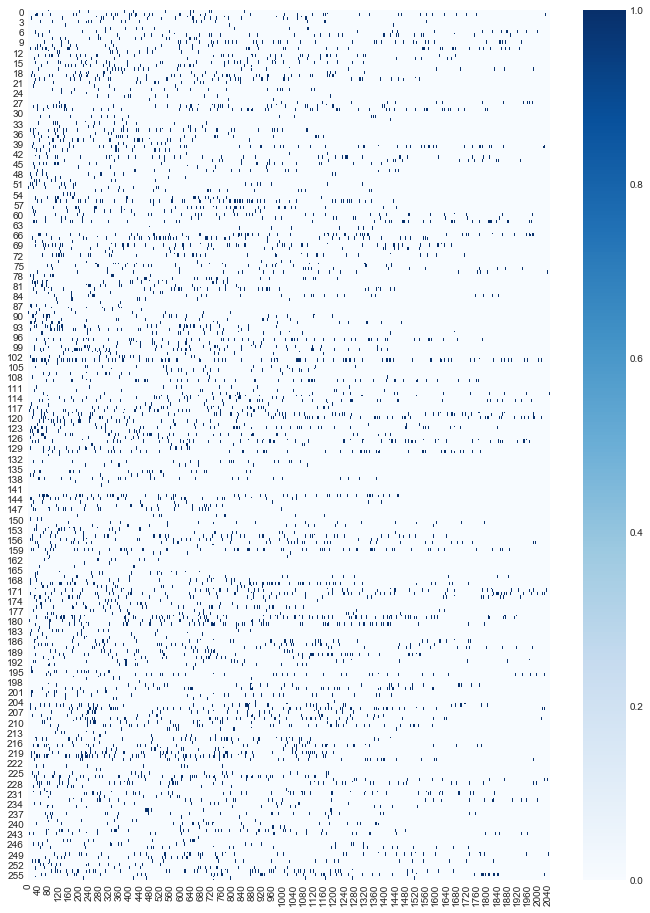

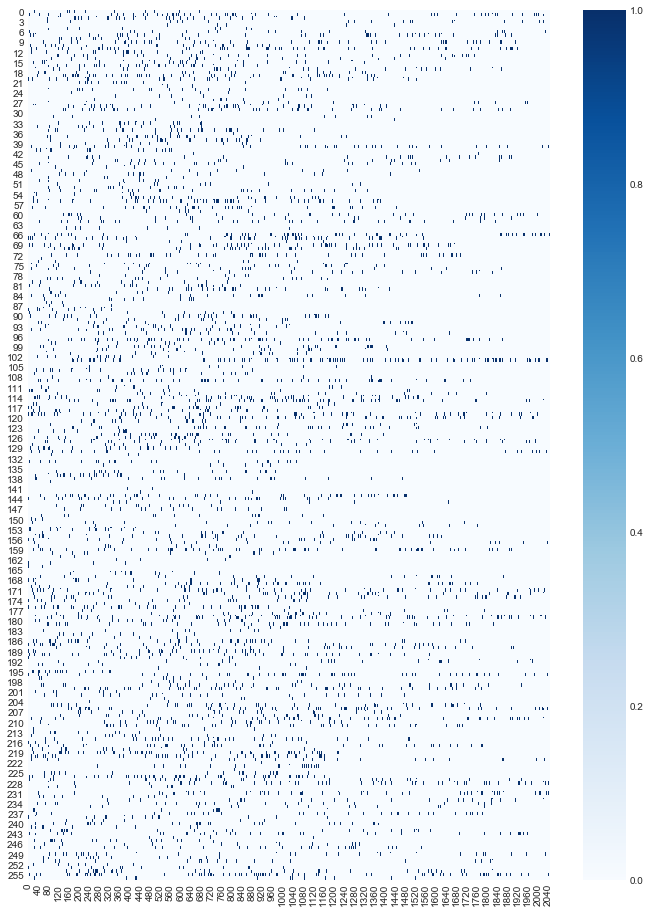

In [86]:
#
# Heatmap of metadata over input sequences
#
import seaborn as sns
import matplotlib.pyplot as plt
import csv

def generate_heatmap(notes_file, icd_desc_file, seq_len, reverse=False):
    hadmid_to_icd = {}
    with open(icd_desc_file) as fi:
        icd_reader = csv.reader(fi, delimiter='\t')
        for row in icd_reader:
            hadmid = row[0]
            icd_desc = " ".join(row[1:])
            hadmid_to_icd[hadmid] = set(icd_desc.lower().split(" "))
    
    heat = []
    r = 0
    with open(notes_file) as fn:
        notes_reader = csv.reader(fn, delimiter='\t')
        for row in notes_reader:
            hadmid = row[0]
            line = row[1].lower().split(" ")
            if reverse:
                line.reverse()
            heat_row = [0] * seq_len
            i = 0
            for word in line:
                if i >= seq_len:
                    break
                if word in hadmid_to_icd[hadmid]:
                    heat_row[i] = 1
                i += 1
            heat.append(heat_row)
            r += 1
            if r > 256:
                break

    a4_dims = (11.7, 16)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.heatmap(ax=ax, data=heat, cmap='Blues')
    plt.show()
            
generate_heatmap("../data_v2/notes.processed.txt", "../data_v2/icd-desc.processed.txt", 2048, reverse=False)
generate_heatmap("../data_v2/notes.processed.txt", "../data_v2/icd-desc.processed.txt", 2048, reverse=True)
            


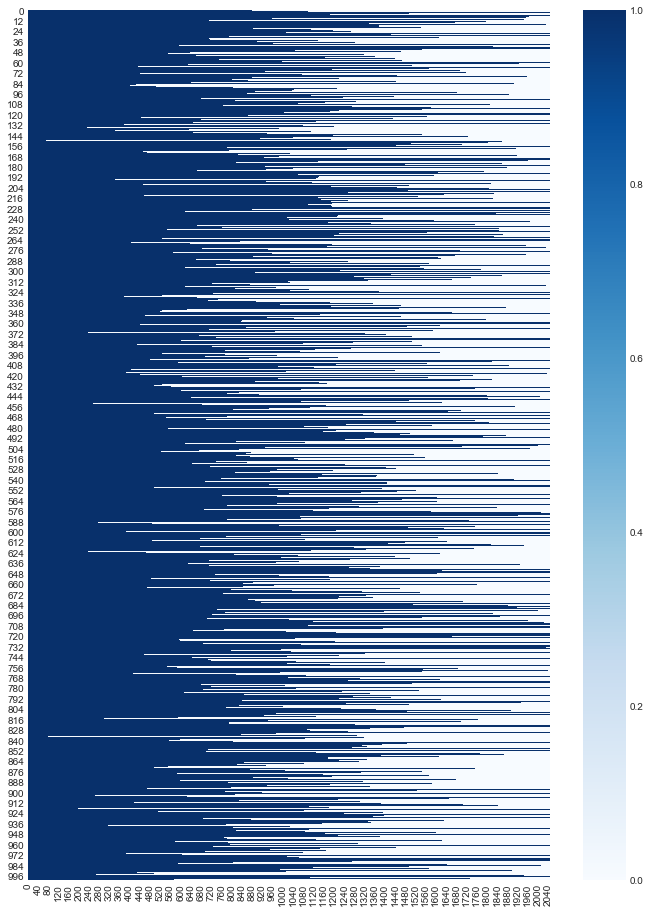

In [84]:
#
# Heatmap of length of input sequences
#
import seaborn as sns
import matplotlib.pyplot as plt
import csv

def generate_heatmap_lengths(notes_file, seq_len):
    heat = []
    r = 0
    with open(notes_file) as fn:
        notes_reader = csv.reader(fn, delimiter='\t')
        for row in notes_reader:
            hadmid = row[0]
            line = row[1].lower().split(" ")
            heat_row = [0] * seq_len
            i = 0
            for word in line:
                if i >= seq_len:
                    break
                heat_row[i] = 1
                i += 1
            heat.append(heat_row)
            r += 1
            if r > 1000:
                break

    a4_dims = (11.7, 16)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.heatmap(ax=ax, data=heat, cmap='Blues')
    plt.show()
            
generate_heatmap_lengths("../data_v2/notes.processed.txt", 2048)
            


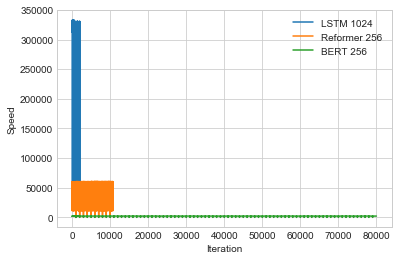

LSTM 1024: 300041.161980198 words/sec
Reformer 256: 26763.033208417946 words/sec
BERT 256: 2264.941959492435 words/sec


In [35]:
#
# Comparisons of model speeds
# 

iterations_1, losses_1, speeds_1, time_takens_1 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.baseline.2")
iterations_2, losses_2, speeds_2, time_takens_2 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.bert.2")
iterations_3, losses_3, speeds_3, time_takens_3 = read_logs_for_training_graph_per_iteration("../logs/nohup.out.reformer.6")

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Speed')
plt.plot(iterations_1, speeds_1, label='LSTM 1024')
plt.plot(iterations_3, speeds_3, label='Reformer 256')
plt.plot(iterations_2, speeds_2, label='BERT 256')
plt.legend()
plt.show()

print("LSTM 1024: {} words/sec".format(np.mean(speeds_1)))
print("Reformer 256: {} words/sec".format(np.mean(speeds_3)))
print("BERT 256: {} words/sec".format(np.mean(speeds_2)))



LSTM 1024: 0.38907503584972214
BioBERT 256: 0.5095771857055819
Reformer 2048: 0.4895166175979945
Reformer Metadata-Augmented 512: nan


/opt/miniconda3/envs/drcoding/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


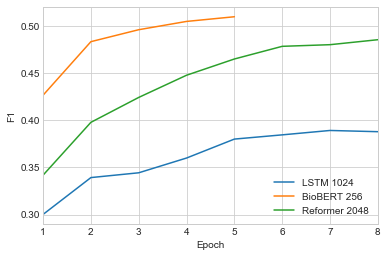

In [39]:
#
# Overall comparisons between models
# 

epochs_1, precisions_1, recalls_1, f1s_1, accuracies_1 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.baseline.2")
epochs_2, precisions_2, recalls_2, f1s_2, accuracies_2 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.bert.2")
epochs_3, precisions_3, recalls_3, f1s_3, accuracies_3 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.4")
epochs_4, precisions_4, recalls_4, f1s_4, accuracies_4 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.metadata.9")


print("LSTM 1024: {}".format(np.max(f1s_1)))
print("BioBERT 256: {}".format(np.max(f1s_2)))
print("Reformer 2048: {}".format(np.max(f1s_3)))
# print("Reformer Metadata-Augmented 512: {}".format(np.max(f1s_4)))


# plt.figure()
# plt.xlabel('Iteration')
# plt.ylabel('Recall')
# plt.plot(epochs_1, recalls_1, label='LSTM 1024')
# plt.plot(epochs_2, recalls_2, label='BERT 256')
# plt.plot(epochs_3, recalls_3, label='Reformer 2048')
# plt.legend()
# plt.show()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.plot(epochs_1, f1s_1, label='LSTM 1024')
plt.plot(epochs_2, f1s_2, label='BioBERT 256')
plt.plot(epochs_3, f1s_3, label='Reformer 2048')
plt.xlim([1, 8])
plt.legend()
plt.show()



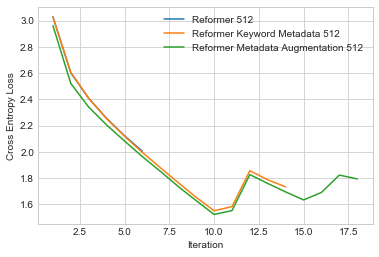

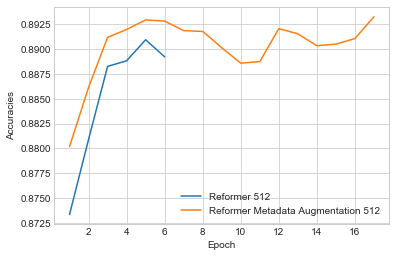

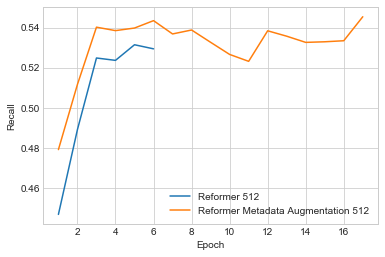

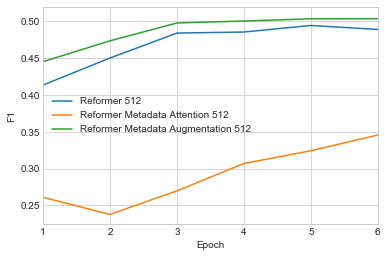

Reformer 512: 0.49429170223593655
Reformer 512 (Metadata Attention): 0.3724987102447575
Reformer 512 (Metadata Augmentation): 0.5061357646979555


In [48]:
#
# Reformer vs Reformer Keyword Metadata
# 


iterations_0, losses_0, speeds_0, time_takens_0 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.baseline.2")
iterations_1, losses_1, speeds_1, time_takens_1 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.reformer.7")
iterations_2, losses_2, speeds_2, time_takens_2 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.reformer.metadata.8")
iterations_3, losses_3, speeds_3, time_takens_3 = read_logs_for_training_graph_per_epoch("../logs/nohup.out.reformer.metadata.9")

losses_1 = [l * 10 for l in losses_1]

plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.plot(iterations_1, losses_1, label='Reformer 512')
plt.plot(iterations_2, losses_2, label='Reformer Keyword Metadata 512')
plt.plot(iterations_3, losses_3, label='Reformer Metadata Augmentation 512')
plt.legend()
plt.show()


epochs_0, precisions_0, recalls_0, f1s_0, accuracies_0 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.baseline.2")
epochs_1, precisions_1, recalls_1, f1s_1, accuracies_1 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.7")
epochs_2, precisions_2, recalls_2, f1s_2, accuracies_2 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.metadata.3")
epochs_3, precisions_3, recalls_3, f1s_3, accuracies_3 = read_logs_for_validation_graph_per_epoch("../logs/nohup.out.reformer.metadata.9")

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracies')
plt.plot(epochs_1, accuracies_1, label='Reformer 512')
# plt.plot(epochs_2, accuracies_2, label='Reformer Keyword Metadata 512')
plt.plot(epochs_3, accuracies_3, label='Reformer Metadata Augmentation 512')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.plot(epochs_1, recalls_1, label='Reformer 512')
# plt.plot(epochs_2, recalls_2, label='Reformer Keyword Metadata 512')
plt.plot(epochs_3, recalls_3, label='Reformer Metadata Augmentation 512')
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('F1')
# plt.plot(epochs_0, f1s_0, label='LSTM Baseline 1024')
plt.plot(epochs_1, f1s_1, label='Reformer 512')
plt.plot(epochs_2, f1s_2, label='Reformer Metadata Attention 512')
plt.plot(epochs_3, f1s_3, label='Reformer Metadata Augmentation 512')
plt.xlim([1, 6])
plt.legend()
plt.show()


print("Reformer 512: {}".format(np.max(f1s_1)))
print("Reformer 512 (Metadata Attention): {}".format(np.max(f1s_2)))
print("Reformer 512 (Metadata Augmentation): {}".format(np.max(f1s_3[:-1])))
